In [66]:
import pandas as pd
import networkx as nx
from datetime import datetime, timedelta

## Utils

In [67]:
def getTrainMaxSpeed(train_id):
    train_id = str(train_id)
    if train_id[0].isdigit():
        return "80"
    elif train_id[0].isalpha():
        if train_id[0] == "G" or train_id[0] == "C":
            return "350"
        elif train_id[0] == "D":
            return "260"
        elif train_id[0] == "Z" or train_id[0] == "T":
            return "160"
        else:
            return "120"

In [68]:
def convertTimetoMinute(time, day):
    if day == "Day 1":
        time_str = time.strftime('%H:%M:%S')
        time_obj = datetime.strptime(time_str, '%H:%M:%S')
        minutes = time_obj.time().hour * 60 + time_obj.time().minute
        return minutes
    elif day == "Day 2":
        time_str = time.strftime('%H:%M:%S')
        time_obj = datetime.strptime(time_str, '%H:%M:%S')
        minutes = time_obj.time().hour * 60 + time_obj.time().minute + 24 * 60
        return minutes
    elif day == "Day 3":
        time_str = time.strftime('%H:%M:%S')
        time_obj = datetime.strptime(time_str, '%H:%M:%S')
        minutes = time_obj.time().hour * 60 + time_obj.time().minute + 24 * 60 * 2
        return minutes

# Network Construction

## Mutli Directed Network

In [69]:
df = pd.read_excel('../data/Railway Data_JL.xlsx')
df

,train,st_no,st_id,date,arr_time,dep_time,stay_time,mileage,lat,lon
0,1095,1,692,Day 1,19:06:00,19:06:00,-,0,37.860480,112.586820
1,1095,2,1351,Day 1,19:27:00,19:32:00,5,27,37.697190,112.731180
2,1095,3,698,Day 1,19:59:00,20:01:00,2,63,37.421360,112.570320
3,1095,4,944,Day 1,20:31:00,20:35:00,4,108,37.206610,112.168470
4,1095,5,232,Day 1,21:00:00,21:04:00,4,139,37.018470,111.919060
...,...,...,...,...,...,...,...,...,...,...
69633,Z97,1,390,Day 1,13:00:00,13:00:00,-,0,39.896042,116.321152
69634,Z97,2,2175,Day 1,18:41:00,18:47:00,6,707,34.746610,113.659410
69635,Z97,3,1374,Day 1,23:16:00,23:22:00,6,1243,30.528640,114.317010
69636,Z97,4,2265,Day 2,02:35:00,02:41:00,6,1605,28.200063,113.019529


### With outliers time datas (ex: 0.8884 and not 0:53:18)

In [70]:
G = nx.MultiDiGraph()
G

In [71]:
st_no_comp = 0
prev_node = 0
prev_mileage = 0
prev_dep_time = 0
for index, row in df.iterrows():
    if not G.has_node(row["st_id"]):
        G.add_node(row["st_id"], pos=(row["lon"], row["lat"]))
    if row["st_no"] == st_no_comp:
        G.add_edge(prev_node, row["st_id"], arr_time=row["dep_time"], dep_time=prev_dep_time, train=row["train"], train_max_speed=getTrainMaxSpeed(row["train"]), day=row["date"])
        st_no_comp = row["st_no"] + 1
        prev_node = row["st_id"]
        prev_mileage = row["mileage"]
        prev_dep_time = row["dep_time"]
    else:
        prev_dep_time = row["dep_time"]
        st_no_comp = row["st_no"] + 1
        prev_node = row["st_id"]
        prev_mileage = row["mileage"]

In [72]:
G.number_of_nodes()

2719

In [73]:
G.number_of_edges()

64155

In [ ]:
for edge in list(G.edges):
    print(edge,G[edge[0]][edge[1]][edge[2]]["day"], G[edge[0]][edge[1]][edge[2]]["dep_time"], G[edge[0]][edge[1]][edge[2]]["arr_time"], G[edge[0]][edge[1]][edge[2]]["train"], G[edge[0]][edge[1]][edge[2]]["train_max_speed"])

### Without outliers time datas (ex: 0.8884 and not 0:53:18)

In [75]:
G = nx.MultiDiGraph()
G

In [76]:
st_no_comp = 0
prev_node = 0
prev_mileage = 0
prev_dep_time = 0
count_exception = 0
for index, row in df.iterrows():
    if not G.has_node(row["st_id"]):
        G.add_node(row["st_id"], pos=(row["lon"], row["lat"]))
    if row["st_no"] == st_no_comp:
        try:
            row["dep_time"].strftime('%H:%M:%S')
            G.add_edge(prev_node, row["st_id"], arr_time=convertTimetoMinute(row["dep_time"], row["date"]), dep_time=prev_dep_time, train=row["train"], train_max_speed=getTrainMaxSpeed(row["train"]), day=row["date"])
        except:
            count_exception += 1
        # G.add_edge(prev_node, row["st_id"], arr_time=row["dep_time"], dep_time=prev_dep_time, train=row["train"], train_max_speed=getTrainMaxSpeed(row["train"]), day=row["date"])
        st_no_comp = row["st_no"] + 1
        prev_node = row["st_id"]
        prev_mileage = row["mileage"]
        # prev_dep_time = row["dep_time"]
        try:
            prev_dep_time = convertTimetoMinute(row["dep_time"], row["date"])
        except:
            pass
    else:
        try:
            prev_dep_time = convertTimetoMinute(row["dep_time"], row["date"])
        except:
            pass
        # prev_dep_time = row["dep_time"]
        st_no_comp = row["st_no"] + 1
        prev_node = row["st_id"]
        prev_mileage = row["mileage"]

print(count_exception)

6567


In [77]:
G.number_of_nodes()

2719

In [78]:
G.number_of_edges()

57588

In [ ]:
for node in list(G.nodes):
    print(node, G.out_edges(node))

In [ ]:
for edge in list(G.edges):
    print(edge,G[edge[0]][edge[1]][edge[2]]["day"], G[edge[0]][edge[1]][edge[2]]["dep_time"], G[edge[0]][edge[1]][edge[2]]["arr_time"], G[edge[0]][edge[1]][edge[2]]["train"], G[edge[0]][edge[1]][edge[2]]["train_max_speed"])

## Simplified Single Directed network

In [81]:
SG = G

for edge in list(SG.edges):
    if edge[2] != 0:
        SG.remove_edge(edge[0], edge[1], key=edge[2])

In [82]:
SG.number_of_nodes()

2719

In [83]:
SG.number_of_edges()

9274

## Undirected network only spatial

In [84]:
SG = SG.to_undirected(reciprocal=False)

In [85]:
SG.number_of_nodes()

2719

In [86]:
SG.number_of_edges()

5362

In [ ]:
for edge,data in list(SG.nodes(data=True)):
    print(edge, data)

In [88]:
pos = nx.get_node_attributes(SG, 'pos')

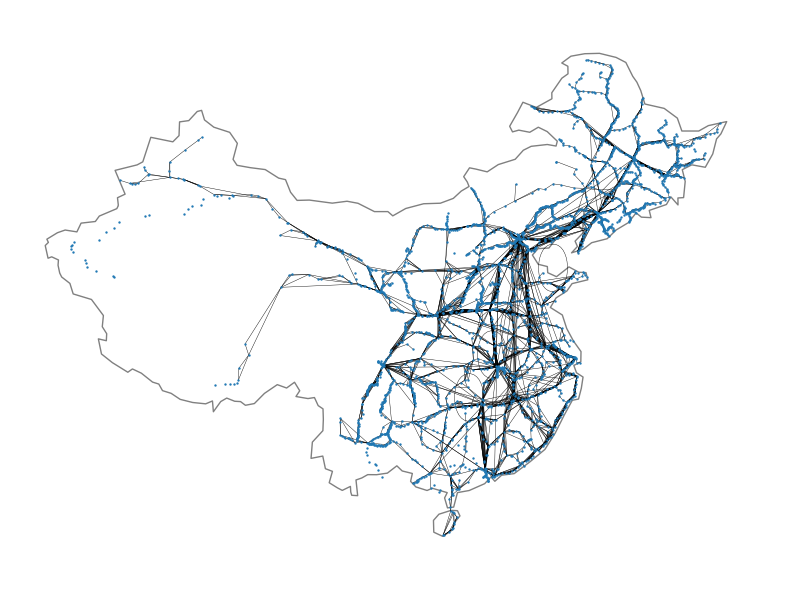

In [90]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
china = world[world["name"] == "China"]
china.plot(linewidth=1, edgecolor="grey", facecolor="white", figsize=(10,10))
nx.draw(SG,pos,node_size=0.5, width=0.3, )

In [ ]:
from libpysal import weights
import matplotlib.pyplot as plt
import networkx as nx
import geopandas
import numpy as np

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
world.plot(linewidth=1, edgecolor="grey", facecolor="white")

network_zone = world[world["name"] == "China"]
network_zone.plot(linewidth=1, edgecolor="grey", facecolor="lightblue")

world.head()

# To plot with networkx, we need to merge the nodes back to
# their positions in order to plot in networkx
positions = dict(zip(G.nodes, pos))

# # plot with a nice basemap
# ax = european_regions.plot(linewidth=1, edgecolor="grey", facecolor="lightblue")
# ax.axis([-12, 45, 33, 66])
# ax.axis("off")
# nx.draw(graph, positions, ax=ax, node_size=5, node_color="r")
# plt.show()
#
# # An alternative method to construct graphs from polygons may use
# # pygeos. This package is a high-performance interface to the GEOS C
# # library, used in computing geographical relationships. These let us
# # describe the relationships between "point sets," like polygons whether
# # or not a line "crosses" a polygon, or whether two polygons "touch."
# # These relationships, called "predicates", are extensive, and are documented
# # by the pygeos package.